In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load Dataset and Visualize the Data Using 2 Different Graphs

In [2]:
df = pd.read_csv('shopping_trends.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (3900, 18)

Column Names:
['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category', 'Purchase Amount (USD)', 'Location', 'Size', 'Color', 'Season', 'Review Rating', 'Subscription Status', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Previous Purchases', 'Payment Method', 'Frequency of Purchases']

First 5 rows:


Customer ID  Age Gender Item Purchased  Category  Purchase Amount (USD)  \
0            1   55   Male         Blouse  Clothing                     53   
1            2   19   Male        Sweater  Clothing                     64   
2            3   50   Male          Jeans  Clothing                     73   
3            4   21   Male        Sandals  Footwear                     90   
4            5   45   Male         Blouse  Clothing                     49   

        Location Size      Color  Season  Review Rating Subscription Status  \
0       Kentucky    L       Gray  Winter            3.1                 Yes   
1          Maine    L     Maroon  Winter            3.1                 Yes   
2  Massachusetts    S     Maroon  Spring            3.1                 Yes   
3   Rhode Island    M     Maroon  Spring            3.5                 Yes   
4         Oregon    M  Turquoise  Spring            2.7                 Yes   

   Shipping Type Discount Applied Promo Code Used  Previous Purchases  \
0        Express              Yes             Yes                  14   
1        Express              Yes             Yes                   2   
2  Free Shipping              Yes             Yes                  23   
3   Next Day Air              Yes             Yes                  49   
4  Free Shipping              Yes             Yes                  31   

  Payment Method Frequency of Purchases  
0          Venmo            Fortnightly  
1           Cash            Fortnightly  
2    Credit Card                 Weekly  
3         PayPal                 Weekly  
4         PayPal               Annually

In [3]:
print("Dataset Info:")
print(df.info())
print("\nDataset Description:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         39

Customer ID          Age  Purchase Amount (USD)  Review Rating  \
count  3900.000000  3900.000000            3900.000000    3900.000000   
mean   1950.500000    44.068462              59.764359       3.749949   
std    1125.977353    15.207589              23.685392       0.716223   
min       1.000000    18.000000              20.000000       2.500000   
25%     975.750000    31.000000              39.000000       3.100000   
50%    1950.500000    44.000000              60.000000       3.700000   
75%    2925.250000    57.000000              81.000000       4.400000   
max    3900.000000    70.000000             100.000000       5.000000   

       Previous Purchases  
count         3900.000000  
mean            25.351538  
std             14.447125  
min              1.000000  
25%             13.000000  
50%             25.000000  
75%             38.000000  
max             50.000000

### Visualization 1: Purchase Amount Distribution Analysis


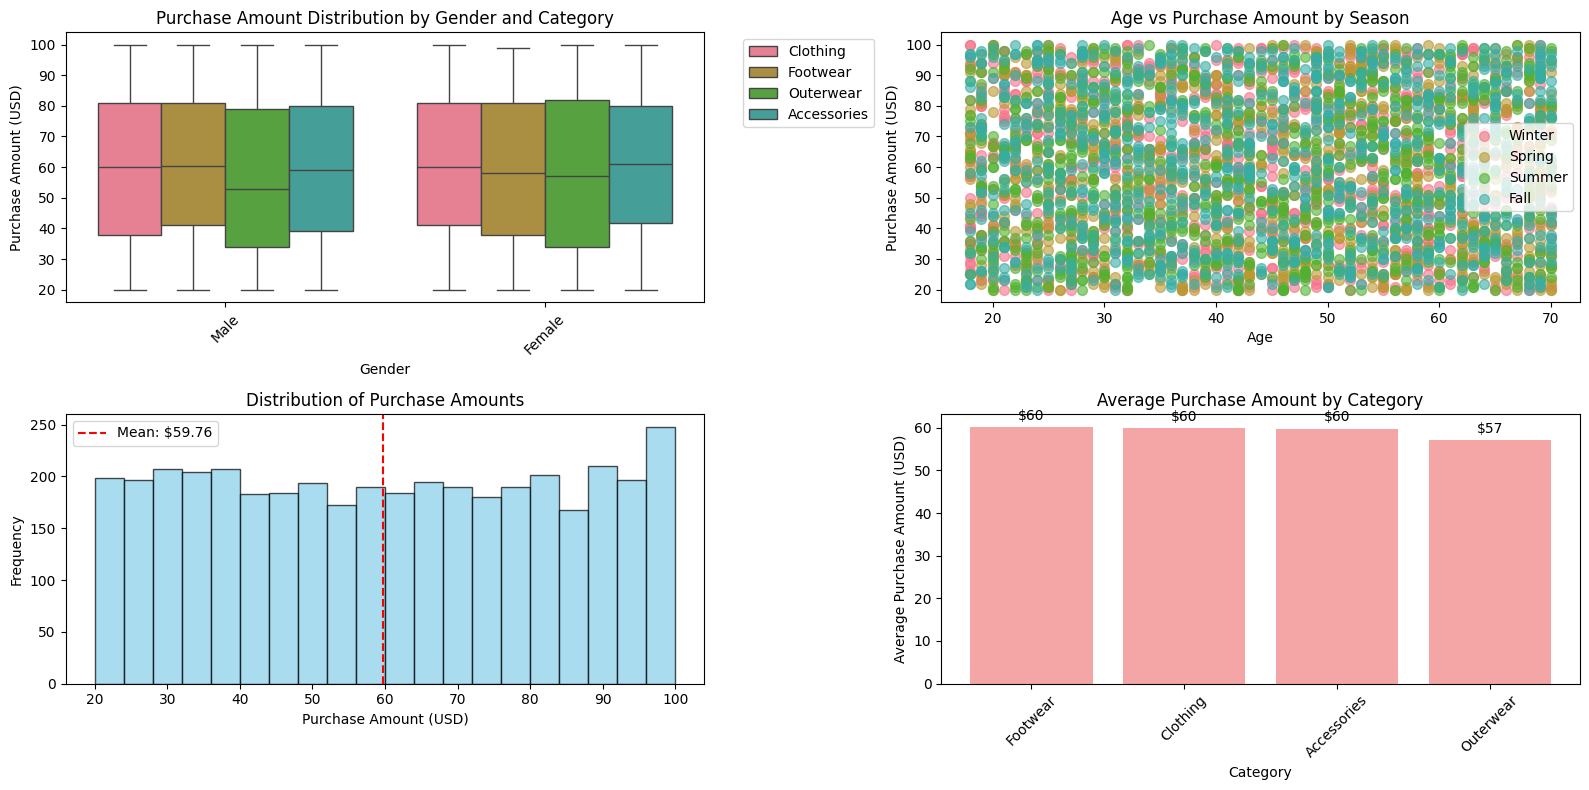

In [4]:
plt.figure(figsize=(16, 8))

# Subplot 1: Purchase Amount by Gender and Category
plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='Gender', y='Purchase Amount (USD)', hue='Category')
plt.title('Purchase Amount Distribution by Gender and Category')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Subplot 2: Age vs Purchase Amount colored by Season
plt.subplot(2, 2, 2)
seasons = df['Season'].unique()
colors = ['spring', 'summer', 'autumn', 'winter']
for i, season in enumerate(seasons):
    season_data = df[df['Season'] == season]
    plt.scatter(season_data['Age'], season_data['Purchase Amount (USD)'], 
               label=season, alpha=0.6, s=50)
plt.xlabel('Age')
plt.ylabel('Purchase Amount (USD)')
plt.title('Age vs Purchase Amount by Season')
plt.legend()

# Subplot 3: Purchase Amount Distribution
plt.subplot(2, 2, 3)
plt.hist(df['Purchase Amount (USD)'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(df['Purchase Amount (USD)'].mean(), color='red', linestyle='--', 
           label=f'Mean: ${df["Purchase Amount (USD)"].mean():.2f}')
plt.xlabel('Purchase Amount (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Purchase Amounts')
plt.legend()

# Subplot 4: Category vs Average Purchase Amount
plt.subplot(2, 2, 4)
category_avg = df.groupby('Category')['Purchase Amount (USD)'].mean().sort_values(ascending=False)
bars = plt.bar(category_avg.index, category_avg.values, color='lightcoral', alpha=0.7)
plt.title('Average Purchase Amount by Category')
plt.xlabel('Category')
plt.ylabel('Average Purchase Amount (USD)')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, category_avg.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'${value:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Visualization 2: Customer Behavior and Preference Analysis


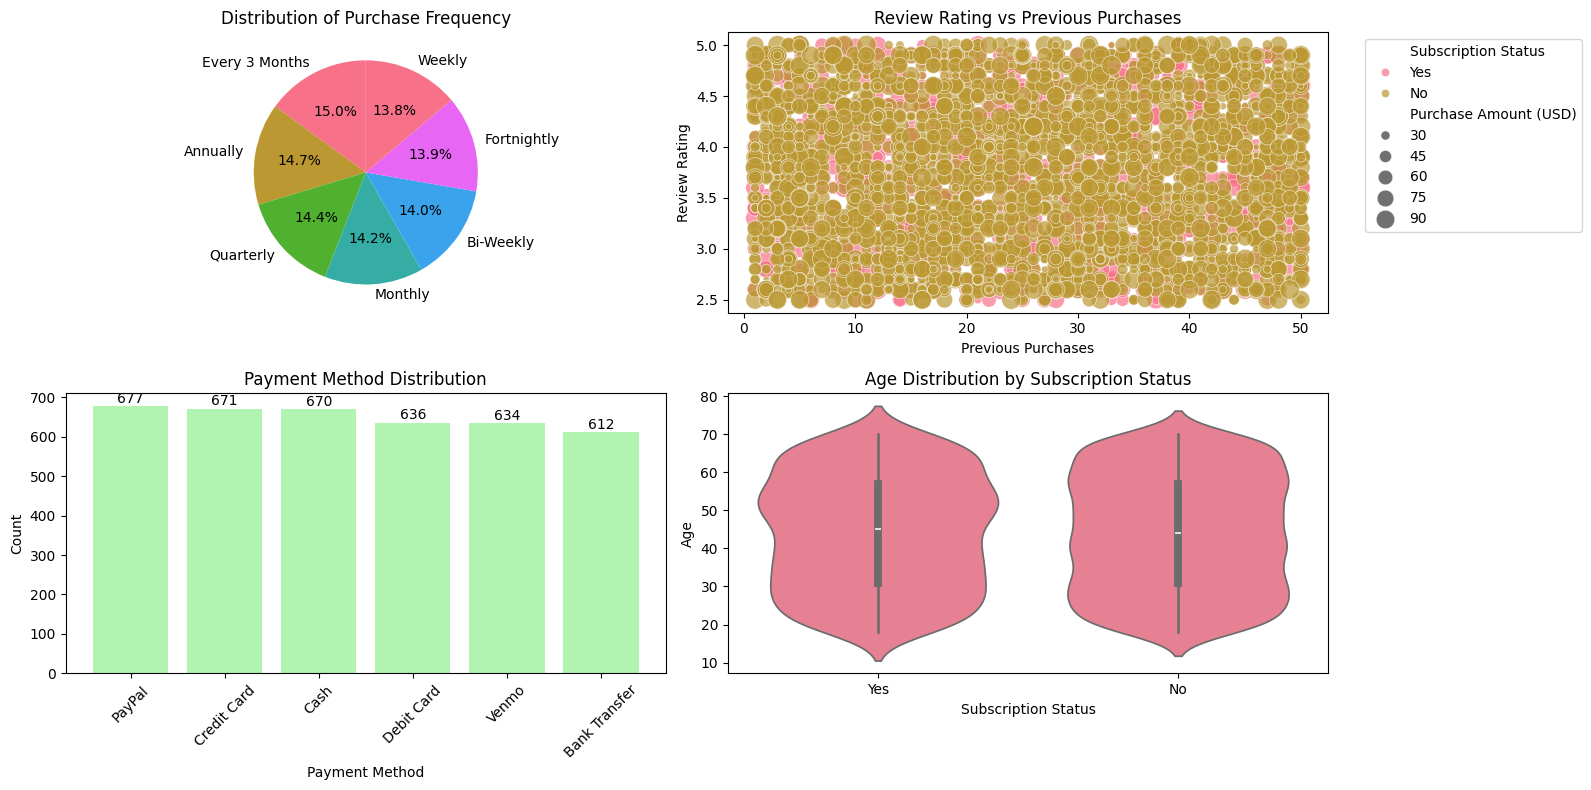

In [5]:
plt.figure(figsize=(16, 8))

# Subplot 1: Frequency of Purchases Distribution
plt.subplot(2, 2, 1)
frequency_counts = df['Frequency of Purchases'].value_counts()
plt.pie(frequency_counts.values, labels=frequency_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Purchase Frequency')

# Subplot 2: Review Rating vs Previous Purchases
plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='Previous Purchases', y='Review Rating', 
                hue='Subscription Status', size='Purchase Amount (USD)', 
                sizes=(20, 200), alpha=0.7)
plt.title('Review Rating vs Previous Purchases')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Subplot 3: Payment Method Distribution
plt.subplot(2, 2, 3)
payment_counts = df['Payment Method'].value_counts()
bars = plt.bar(payment_counts.index, payment_counts.values, color='lightgreen', alpha=0.7)
plt.title('Payment Method Distribution')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add value labels
for bar, value in zip(bars, payment_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{value}', ha='center', va='bottom')

# Subplot 4: Age Distribution by Subscription Status
plt.subplot(2, 2, 4)
sns.violinplot(data=df, x='Subscription Status', y='Age')
plt.title('Age Distribution by Subscription Status')
plt.xlabel('Subscription Status')
plt.ylabel('Age')

plt.tight_layout()
plt.show()

In [6]:
## 2. Identify Missing Values and Generate a Missing Values Report

COMPREHENSIVE MISSING VALUES REPORT

SUMMARY STATISTICS:
Total missing values: 0
Columns with missing values: 0
Percentage of complete rows: 100.00%
Total rows: 3900
Total columns: 18


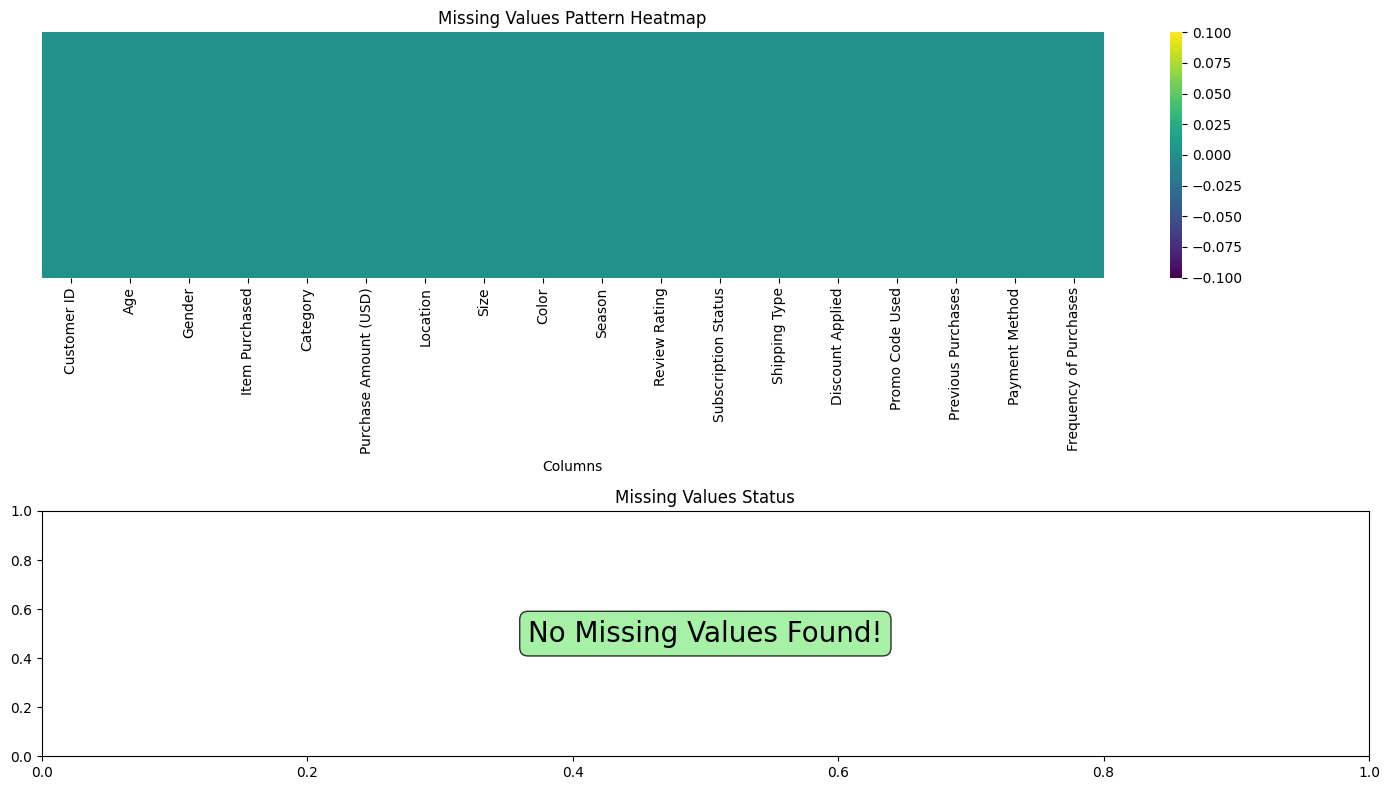


✅ EXCELLENT! No missing values found in the dataset!
The dataset is complete and ready for analysis.


In [7]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Create comprehensive missing values report
missing_report = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes,
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage,
    'Non-Null Count': df.count(),
    'Total Count': len(df)
})

print("COMPREHENSIVE MISSING VALUES REPORT")
print("=" * 50)
missing_report.round(2)

print(f"\nSUMMARY STATISTICS:")
print(f"Total missing values: {missing_values.sum()}")
print(f"Columns with missing values: {sum(missing_values > 0)}")
print(f"Percentage of complete rows: {(len(df) - df.isnull().any(axis=1).sum()) / len(df) * 100:.2f}%")
print(f"Total rows: {len(df)}")
print(f"Total columns: {len(df.columns)}")

# Visualize missing values pattern
plt.figure(figsize=(14, 8))

# Subplot 1: Missing values heatmap
plt.subplot(2, 1, 1)
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Values Pattern Heatmap')
plt.xlabel('Columns')

# Subplot 2: Missing values count by column
plt.subplot(2, 1, 2)
missing_counts = df.isnull().sum()
if missing_counts.sum() > 0:
    missing_counts_nonzero = missing_counts[missing_counts > 0]
    bars = plt.bar(missing_counts_nonzero.index, missing_counts_nonzero.values, 
                   color='red', alpha=0.7)
    plt.title('Missing Values Count by Column')
    plt.xlabel('Columns')
    plt.ylabel('Missing Count')
    plt.xticks(rotation=45)
    
    # Add value labels
    for bar, value in zip(bars, missing_counts_nonzero.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{value}', ha='center', va='bottom')
else:
    plt.text(0.5, 0.5, 'No Missing Values Found!', 
             ha='center', va='center', fontsize=20, 
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title('Missing Values Status')

plt.tight_layout()
plt.show()

# Additional detailed analysis
if missing_values.sum() > 0:
    print("\nDETAILED MISSING VALUES ANALYSIS:")
    print("-" * 40)
    for col in df.columns:
        if missing_values[col] > 0:
            print(f"\n{col}:")
            print(f"  Missing: {missing_values[col]} ({missing_percentage[col]:.2f}%)")
            print(f"  Data type: {df[col].dtype}")
            print(f"  Unique values: {df[col].nunique()}")
            if df[col].dtype == 'object':
                print(f"  Most common values: {df[col].value_counts().head(3).to_dict()}")
else:
    print("\n✅ EXCELLENT! No missing values found in the dataset!")
    print("The dataset is complete and ready for analysis.")

## 3. Select Relevant Features for Clustering

In [8]:
# Analyze all available columns
print("FEATURE SELECTION ANALYSIS")
print("=" * 30)
print("Available columns:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col} ({df[col].dtype})")

# Separate features by type
numerical_features = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']
categorical_features = ['Gender', 'Category', 'Season', 'Subscription Status', 
                       'Shipping Type', 'Frequency of Purchases', 'Payment Method']

print(f"\nSELECTED FEATURES FOR CLUSTERING:")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Create clustering dataset
clustering_df = df[numerical_features + categorical_features].copy()
print(f"\nClustering dataset shape: {clustering_df.shape}")
clustering_df.head()

# Analyze selected features
print("FEATURE ANALYSIS")
print("=" * 20)

# Numerical features analysis
print("\nNumerical Features Statistics:")
clustering_df[numerical_features].describe()


# Categorical features analysis
print("\nCategorical Features Analysis:")
for col in categorical_features:
    unique_values = clustering_df[col].unique()
    print(f"\n{col}:")
    print(f"  Unique values ({len(unique_values)}): {unique_values}")
    print(f"  Value counts: {dict(clustering_df[col].value_counts().head(3))}")

# Encode categorical variables for clustering
print("CATEGORICAL ENCODING")
print("=" * 20)

label_encoders = {}
categorical_encoded = clustering_df[categorical_features].copy()

for col in categorical_features:
    le = LabelEncoder()
    categorical_encoded[col] = le.fit_transform(clustering_df[col])
    label_encoders[col] = le
    
    print(f"\n{col}:")
    print(f"  Original: {clustering_df[col].unique()}")
    print(f"  Encoded:  {categorical_encoded[col].unique()}")
    
    # Create mapping dictionary for reference
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"  Mapping:  {mapping}")

# Combine numerical and encoded categorical features
features_for_clustering = pd.concat([clustering_df[numerical_features], categorical_encoded], axis=1)
print(f"\nFinal features for clustering:")
print(f"Shape: {features_for_clustering.shape}")
print(f"Columns: {features_for_clustering.columns.tolist()}")
features_for_clustering.head()

FEATURE SELECTION ANALYSIS
Available columns:
 1. Customer ID (int64)
 2. Age (int64)
 3. Gender (object)
 4. Item Purchased (object)
 5. Category (object)
 6. Purchase Amount (USD) (int64)
 7. Location (object)
 8. Size (object)
 9. Color (object)
10. Season (object)
11. Review Rating (float64)
12. Subscription Status (object)
13. Shipping Type (object)
14. Discount Applied (object)
15. Promo Code Used (object)
16. Previous Purchases (int64)
17. Payment Method (object)
18. Frequency of Purchases (object)

SELECTED FEATURES FOR CLUSTERING:
Numerical features (4): ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']
Categorical features (7): ['Gender', 'Category', 'Season', 'Subscription Status', 'Shipping Type', 'Frequency of Purchases', 'Payment Method']

Clustering dataset shape: (3900, 11)
FEATURE ANALYSIS

Numerical Features Statistics:

Categorical Features Analysis:

Gender:
  Unique values (2): ['Male' 'Female']
  Value counts: {'Male': np.int64(2652), 'Female

Age  Purchase Amount (USD)  Review Rating  Previous Purchases  Gender  \
0   55                     53            3.1                  14       1   
1   19                     64            3.1                   2       1   
2   50                     73            3.1                  23       1   
3   21                     90            3.5                  49       1   
4   45                     49            2.7                  31       1   

   Category  Season  Subscription Status  Shipping Type  \
0         1       3                    1              1   
1         1       3                    1              1   
2         1       1                    1              2   
3         2       1                    1              3   
4         1       1                    1              2   

   Frequency of Purchases  Payment Method  
0                       3               5  
1                       3               1  
2                       6               2  
3                       6               4  
4                       0               4

## 4. Normalize the Data

DATA NORMALIZATION
Normalization completed successfully!
Original data shape: (3900, 11)
Normalized data shape: (3900, 11)

BEFORE NORMALIZATION:

AFTER NORMALIZATION:


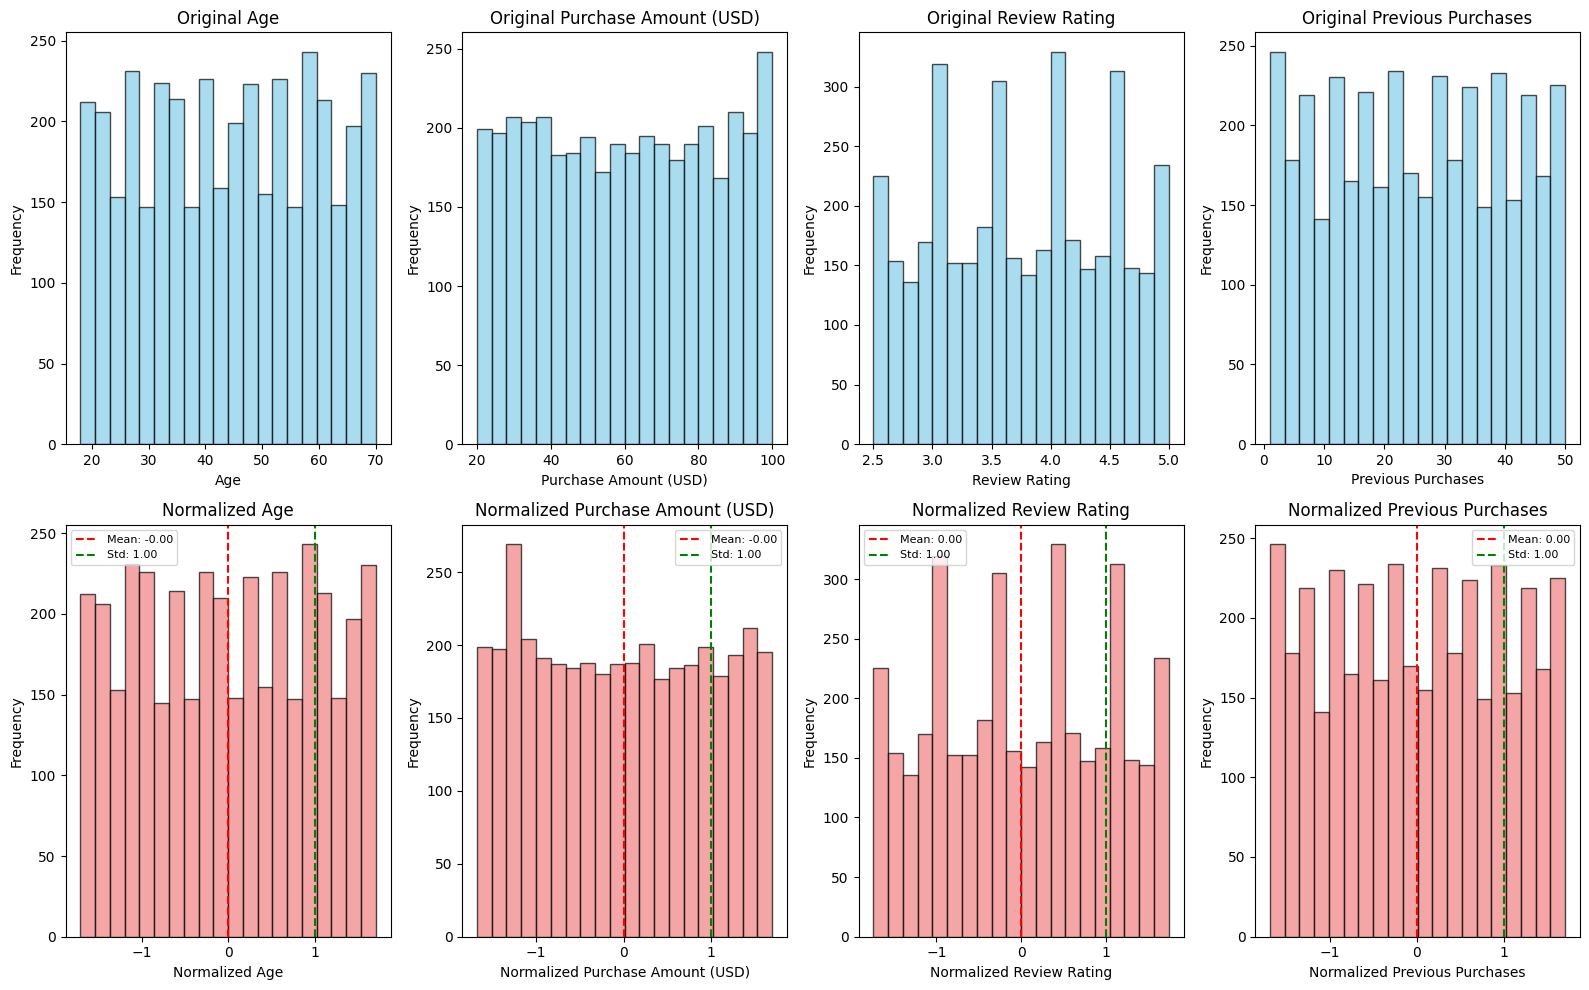


NORMALIZATION VERIFICATION:
Mean of normalized features (should be ~0):
Age                      -0.0
Purchase Amount (USD)    -0.0
Review Rating             0.0
Previous Purchases        0.0
Gender                    0.0
Category                  0.0
Season                    0.0
Subscription Status       0.0
Shipping Type            -0.0
Frequency of Purchases   -0.0
Payment Method           -0.0
dtype: float64

Standard deviation of normalized features (should be ~1):
Age                       1.000128
Purchase Amount (USD)     1.000128
Review Rating             1.000128
Previous Purchases        1.000128
Gender                    1.000128
Category                  1.000128
Season                    1.000128
Subscription Status       1.000128
Shipping Type             1.000128
Frequency of Purchases    1.000128
Payment Method            1.000128
dtype: float64


In [9]:
# Apply data normalization
print("DATA NORMALIZATION")
print("=" * 18)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
normalized_features = scaler.fit_transform(features_for_clustering)

# Convert back to DataFrame for easier handling
normalized_df = pd.DataFrame(normalized_features, columns=features_for_clustering.columns)

print(f"Normalization completed successfully!")
print(f"Original data shape: {features_for_clustering.shape}")
print(f"Normalized data shape: {normalized_df.shape}")

# Display normalization statistics
print("\nBEFORE NORMALIZATION:")
features_for_clustering.describe().round(2)


print("\nAFTER NORMALIZATION:")
normalized_df.describe().round(2)

# Visualize the normalization effect
plt.figure(figsize=(16, 10))

# Select a few key features for visualization
viz_features = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']

for i, feature in enumerate(viz_features, 1):
    # Original data
    plt.subplot(2, 4, i)
    plt.hist(features_for_clustering[feature], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Original {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    
    # Normalized data
    plt.subplot(2, 4, i + 4)
    plt.hist(normalized_df[feature], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title(f'Normalized {feature}')
    plt.xlabel(f'Normalized {feature}')
    plt.ylabel('Frequency')
    
    # Add mean and std lines for normalized data
    plt.axvline(normalized_df[feature].mean(), color='red', linestyle='--', 
                label=f'Mean: {normalized_df[feature].mean():.2f}')
    plt.axvline(normalized_df[feature].std(), color='green', linestyle='--', 
                label=f'Std: {normalized_df[feature].std():.2f}')
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

print("\nNORMALIZATION VERIFICATION:")
print("Mean of normalized features (should be ~0):")
print(normalized_df.mean().round(6))
print("\nStandard deviation of normalized features (should be ~1):")
print(normalized_df.std().round(6))

## 5. Draw the Dendrogram

DENDROGRAM ANALYSIS
Creating dendrograms for linkage methods:
1. Single linkage
2. Complete linkage
3. Average linkage
4. Centroid linkage
5. Ward linkage

Calculating single linkage...

Calculating complete linkage...

Calculating average linkage...

Calculating centroid linkage...

Calculating ward linkage...


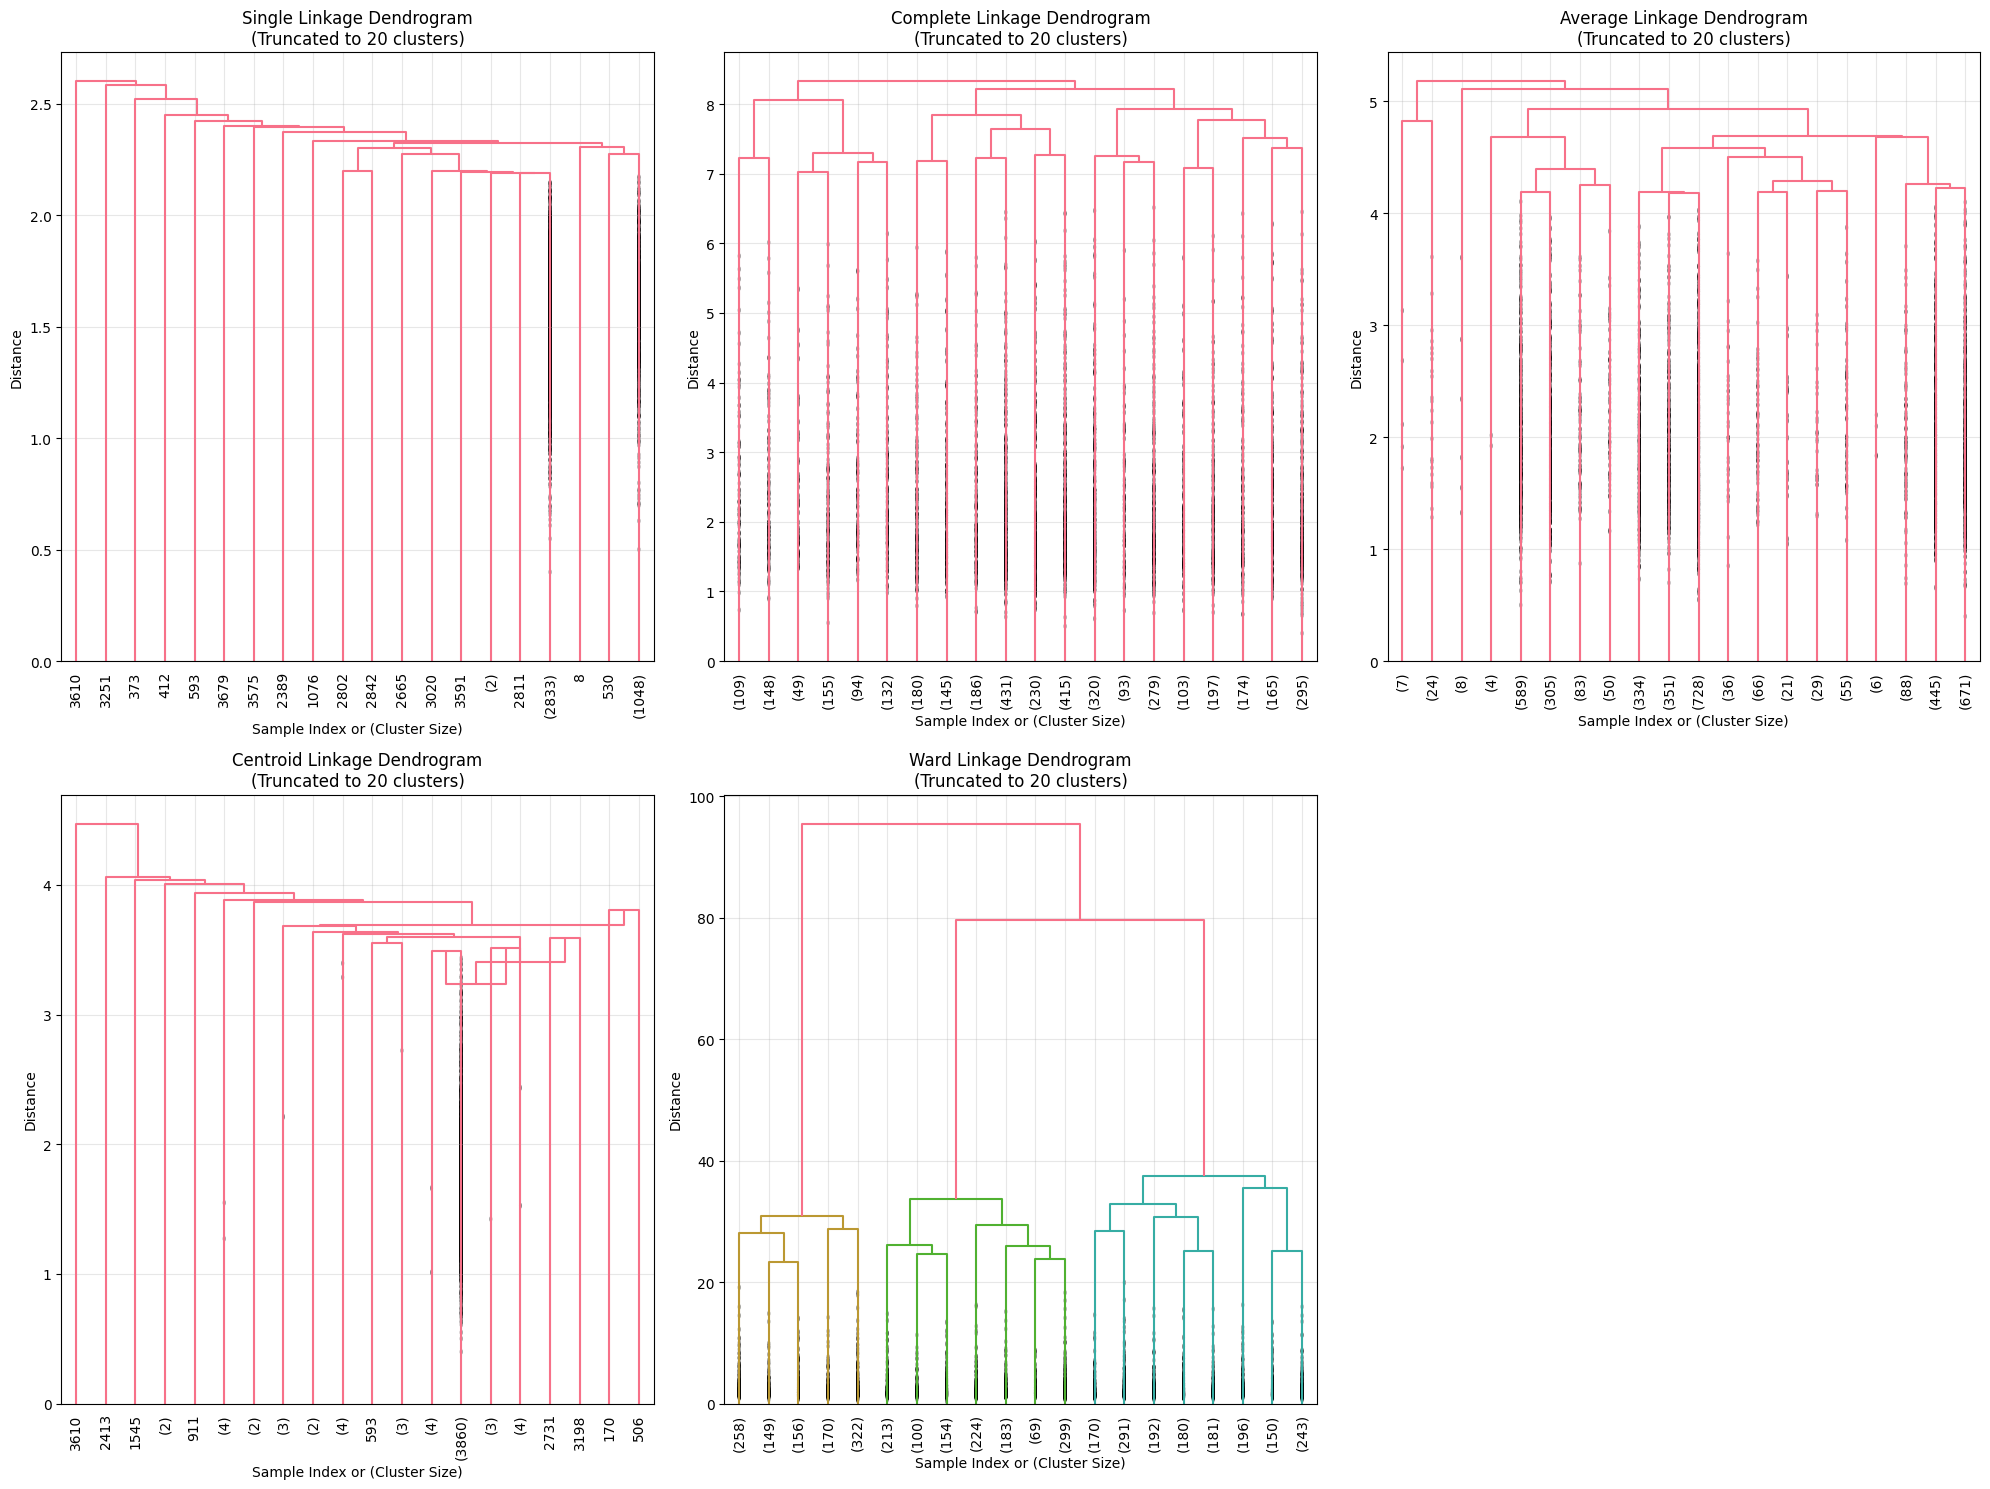


✅ All dendrograms created successfully!

Dendrogram Interpretation:
- Height indicates distance between clusters
- Horizontal lines show cluster merges
- Longer vertical lines suggest natural cluster boundaries
- Use the 'elbow' in the dendrogram to determine optimal cluster count


In [10]:
linkage_methods = ['single', 'complete', 'average', 'centroid', 'ward']

print("DENDROGRAM ANALYSIS")
print("=" * 19)
print("Creating dendrograms for linkage methods:")
for i, method in enumerate(linkage_methods, 1):
    print(f"{i}. {method.capitalize()} linkage")

plt.figure(figsize=(20, 15))

for i, method in enumerate(linkage_methods, 1):
    plt.subplot(2, 3, i)
    
    # Calculate linkage matrix
    print(f"\nCalculating {method} linkage...")
    
    if method == 'centroid':
        Z = linkage(normalized_features, method=method, metric='euclidean')
    elif method == 'ward':
        Z = linkage(normalized_features, method=method)
    else:
        Z = linkage(normalized_features, method=method, metric='euclidean')
    
    # Plot dendrogram
    dendrogram(Z, 
              truncate_mode='lastp', 
              p=20,  # Show last 20 merged clusters
              leaf_rotation=90, 
              leaf_font_size=10,
              show_contracted=True)
    
    plt.title(f'{method.capitalize()} Linkage Dendrogram\n(Truncated to 20 clusters)', fontsize=12)
    plt.xlabel('Sample Index or (Cluster Size)', fontsize=10)
    plt.ylabel('Distance', fontsize=10)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ All dendrograms created successfully!")
print("\nDendrogram Interpretation:")
print("- Height indicates distance between clusters")
print("- Horizontal lines show cluster merges")
print("- Longer vertical lines suggest natural cluster boundaries")
print("- Use the 'elbow' in the dendrogram to determine optimal cluster count")

## 6. Implement Agglomerative Clustering Algorithm with Different Linkage Methods


In [11]:
n_clusters = 4  # You can adjust this based on dendrogram inspection

print("AGGLOMERATIVE CLUSTERING IMPLEMENTATION")
print("=" * 42)
print(f"Number of clusters: {n_clusters}")
print(f"Dataset size: {normalized_features.shape[0]} samples, {normalized_features.shape[1]} features")

# Dictionary to store clustering results
clustering_results = {}

# Implement each linkage method
linkage_methods = ['single', 'complete', 'average', 'centroid', 'ward']

for method in linkage_methods:
    print(f"\n{'-' * 30}")
    print(f"Implementing {method.upper()} Linkage Clustering...")
    
    try:
        # Create clustering model
        agg_clustering = AgglomerativeClustering(
            n_clusters=n_clusters, 
            linkage=method
        )
        
        # Fit the model and predict clusters
        cluster_labels = agg_clustering.fit_predict(normalized_features)
        
        # Store results
        clustering_results[method] = {
            'labels': cluster_labels,
            'model': agg_clustering,
            'n_clusters': n_clusters
        }
        
        # Analyze cluster distribution
        unique, counts = np.unique(cluster_labels, return_counts=True)
        print(f"✅ {method.capitalize()} clustering completed successfully!")
        print(f"Cluster distribution:")
        for cluster, count in zip(unique, counts):
            print(f"  Cluster {cluster}: {count} samples ({count/len(cluster_labels)*100:.1f}%)")
            
    except Exception as e:
        print(f"❌ Error in {method} clustering: {str(e)}")

print(f"\n🎉 All clustering methods implemented successfully!")
print(f"Total methods completed: {len(clustering_results)}")

AGGLOMERATIVE CLUSTERING IMPLEMENTATION
Number of clusters: 4
Dataset size: 3900 samples, 11 features

------------------------------
Implementing SINGLE Linkage Clustering...
✅ Single clustering completed successfully!
Cluster distribution:
  Cluster 0: 3897 samples (99.9%)
  Cluster 1: 1 samples (0.0%)
  Cluster 2: 1 samples (0.0%)
  Cluster 3: 1 samples (0.0%)

------------------------------
Implementing COMPLETE Linkage Clustering...
✅ Complete clustering completed successfully!
Cluster distribution:
  Cluster 0: 1626 samples (41.7%)
  Cluster 1: 430 samples (11.0%)
  Cluster 2: 1587 samples (40.7%)
  Cluster 3: 257 samples (6.6%)

------------------------------
Implementing AVERAGE Linkage Clustering...
✅ Average clustering completed successfully!
Cluster distribution:
  Cluster 0: 31 samples (0.8%)
  Cluster 1: 2830 samples (72.6%)
  Cluster 2: 8 samples (0.2%)
  Cluster 3: 1031 samples (26.4%)

------------------------------
Implementing CENTROID Linkage Clustering...
❌ Error in

## 7. Visualize Clustered Samples and Display Cluster Labels


PCA ANALYSIS FOR VISUALIZATION
PCA explained variance ratio: [0.12962566 0.09736133]
Total variance explained: 0.227


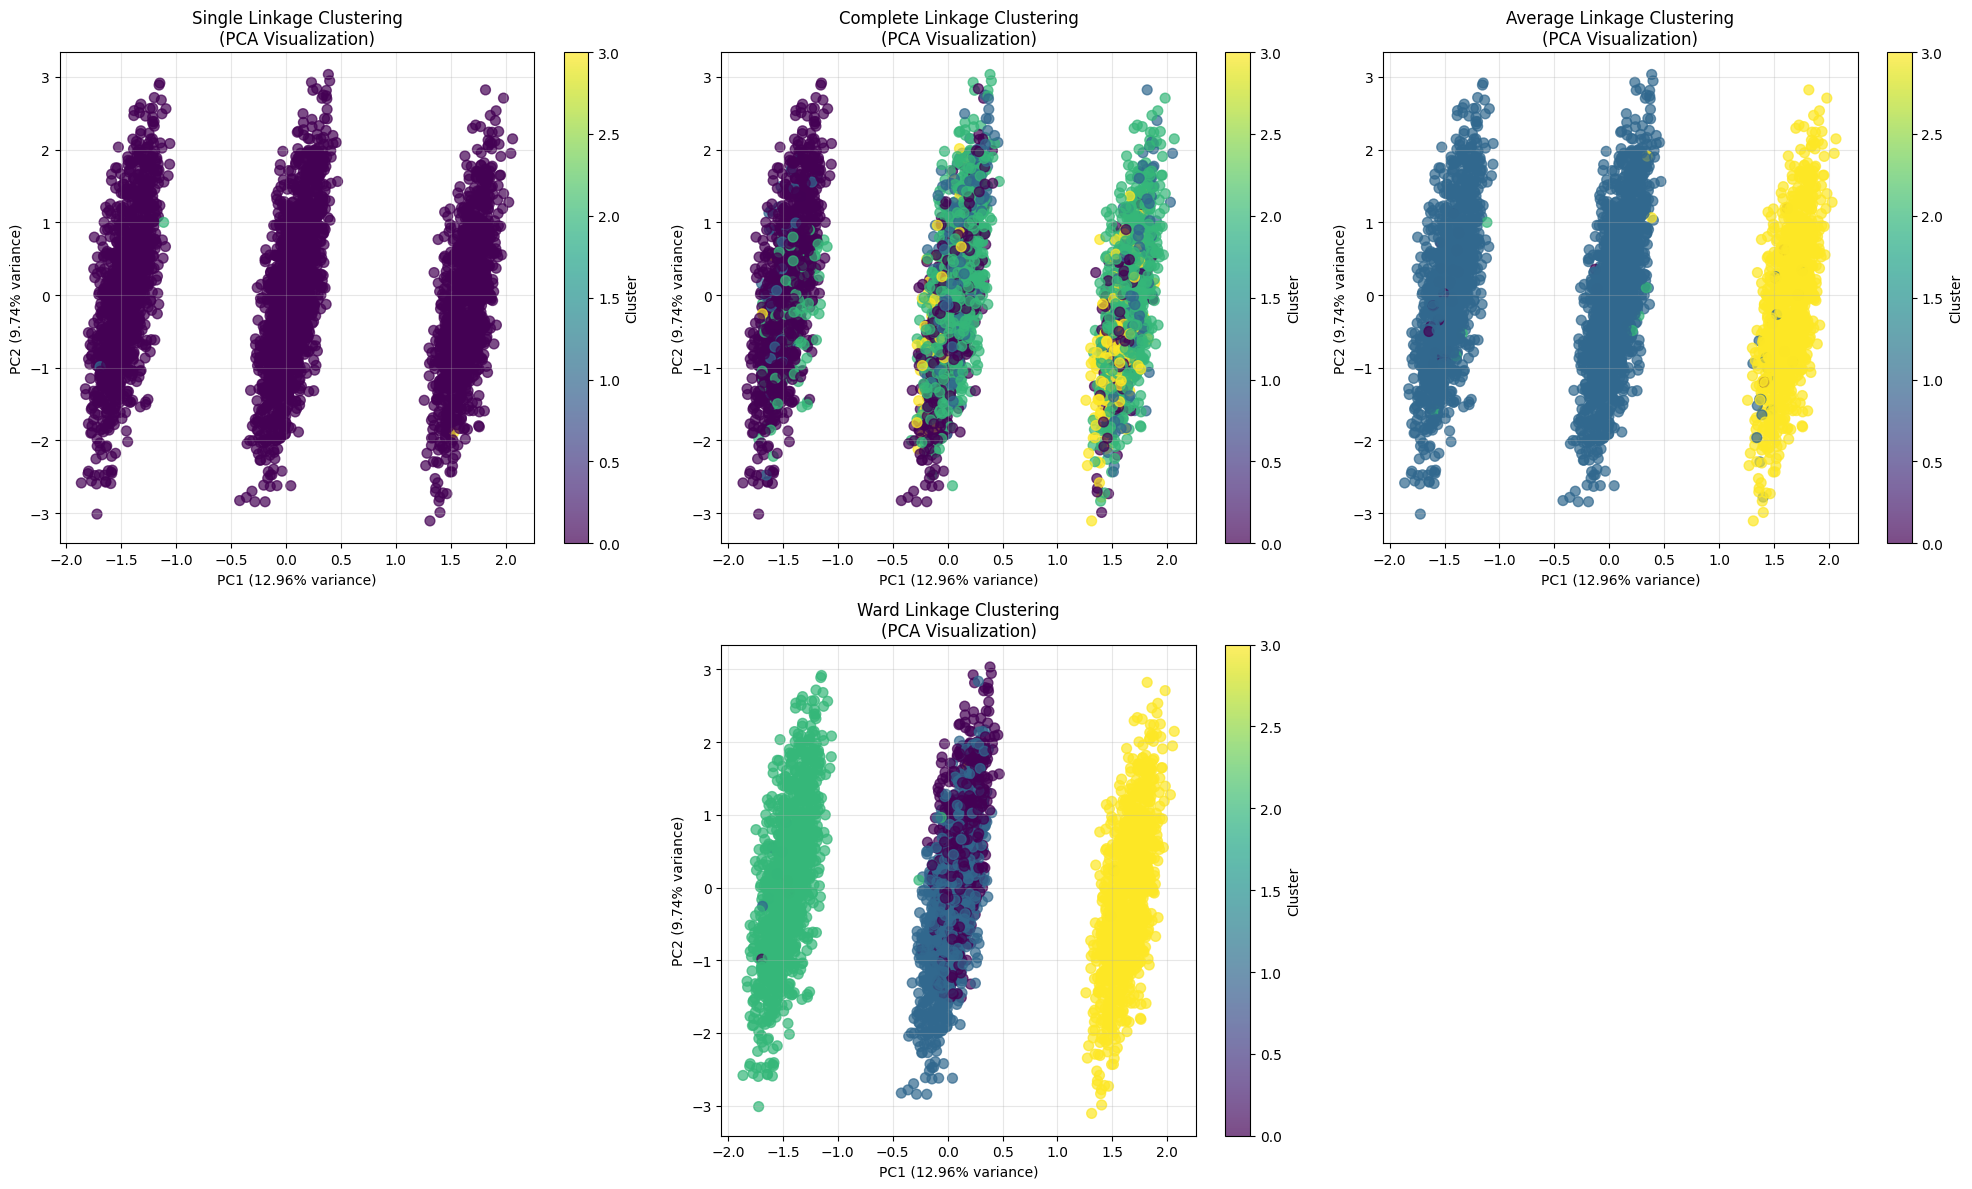

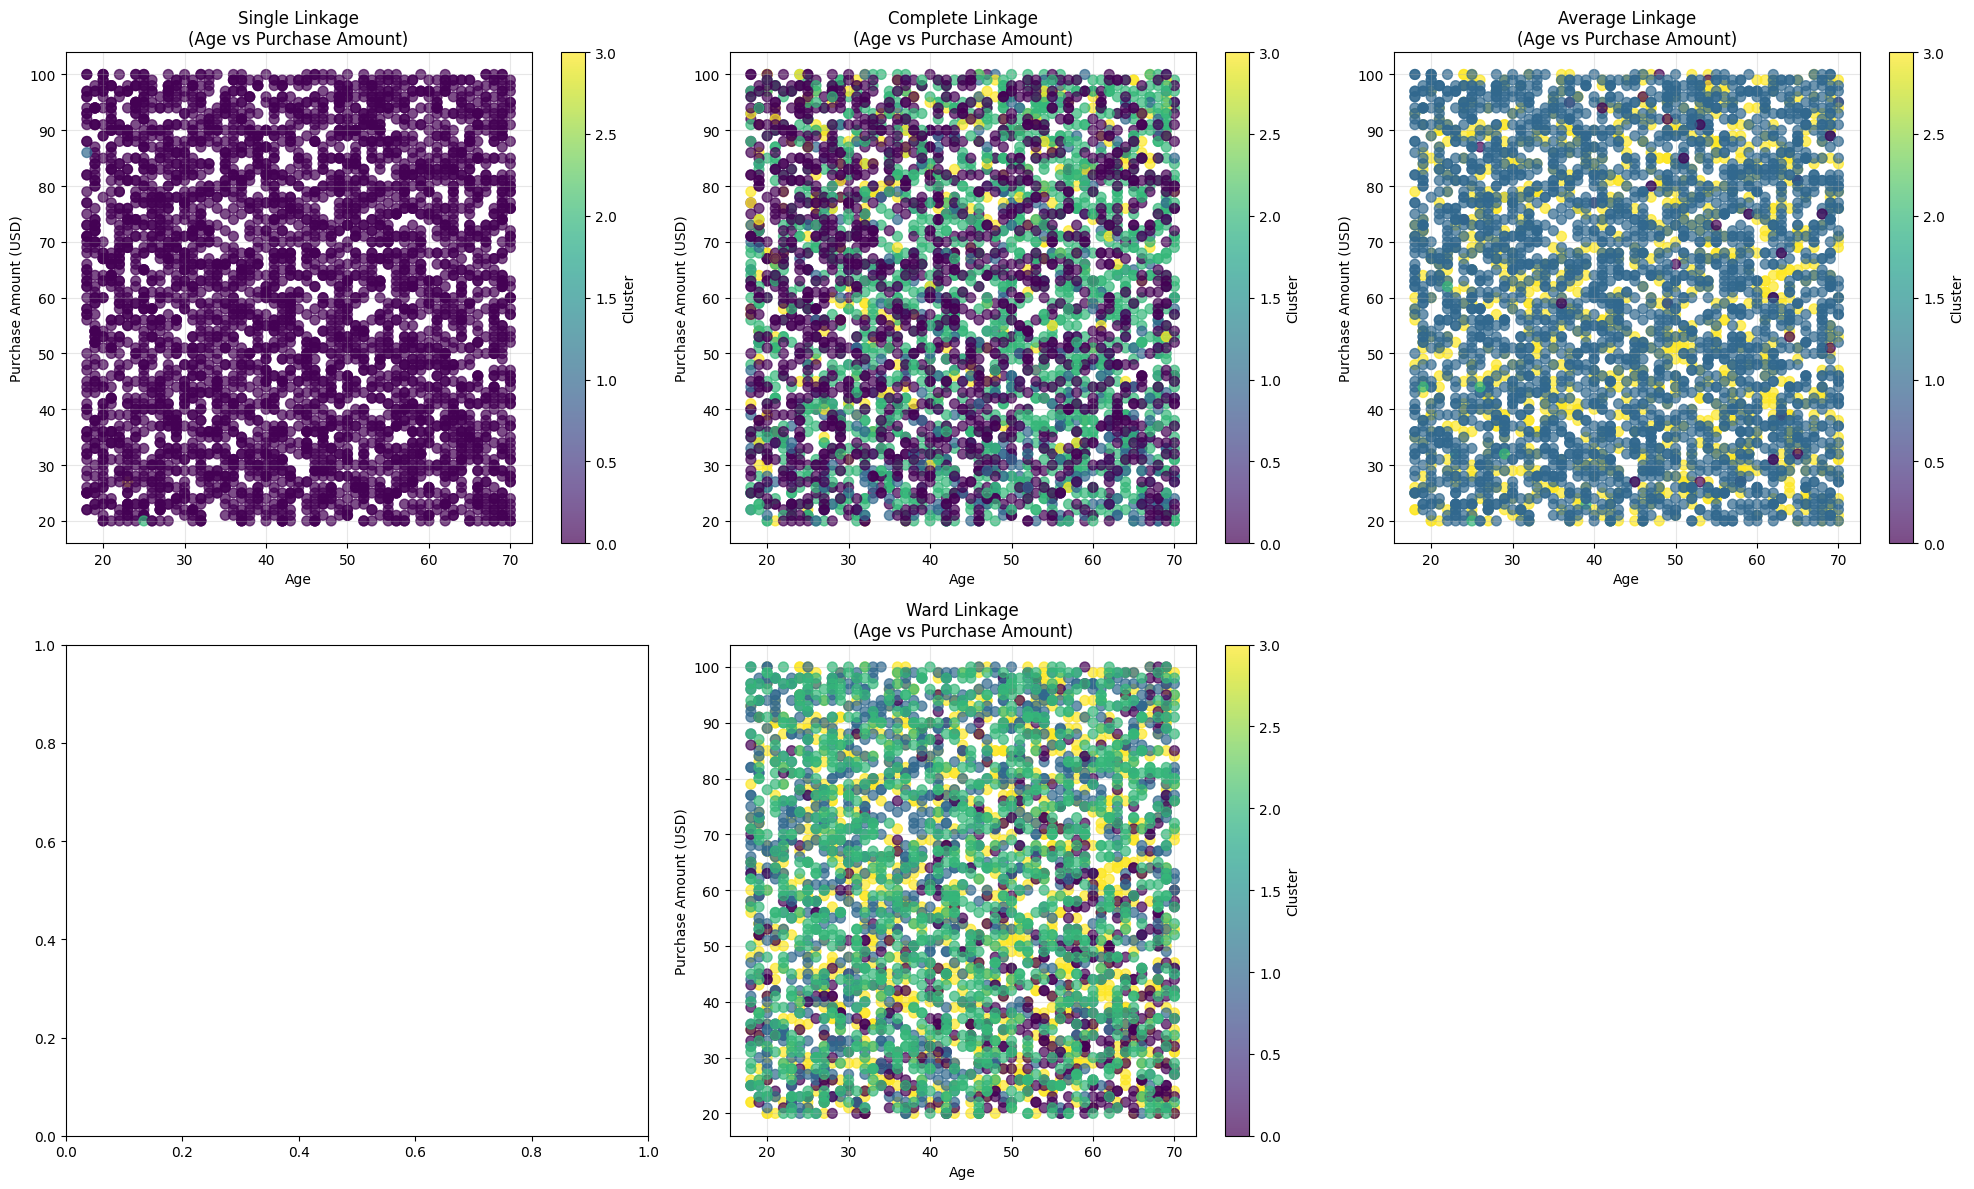

3D PCA explained variance ratio: [0.12962566 0.09736133 0.0965711 ]
Total variance explained: 0.324


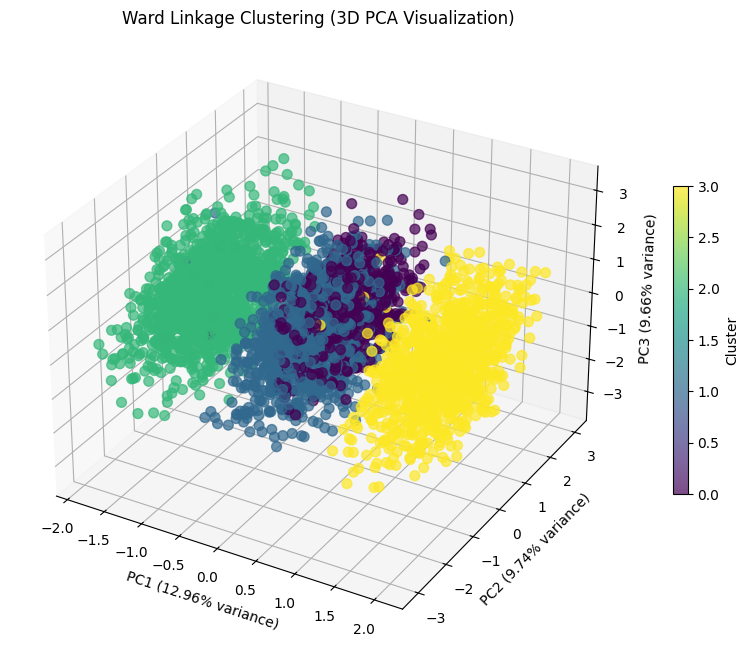

In [12]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(normalized_features)

print("PCA ANALYSIS FOR VISUALIZATION")
print("=" * 30)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.3f}")

# Create visualizations for each clustering method using PCA
plt.figure(figsize=(20, 12))

for i, method in enumerate(linkage_methods, 1):
    if method in clustering_results:
        plt.subplot(2, 3, i)
        
        labels = clustering_results[method]['labels']
        scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
                             c=labels, cmap='viridis', alpha=0.7, s=50)
        plt.title(f'{method.capitalize()} Linkage Clustering\n(PCA Visualization)')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.colorbar(scatter, label='Cluster')
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Alternative visualization using original features (Age vs Purchase Amount)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, method in enumerate(linkage_methods):
    if method in clustering_results:
        labels = clustering_results[method]['labels']
        
        # Scatter plot of Age vs Purchase Amount
        scatter = axes[i].scatter(df['Age'], df['Purchase Amount (USD)'], 
                                 c=labels, cmap='viridis', alpha=0.7, s=50)
        axes[i].set_title(f'{method.capitalize()} Linkage\n(Age vs Purchase Amount)')
        axes[i].set_xlabel('Age')
        axes[i].set_ylabel('Purchase Amount (USD)')
        axes[i].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[i], label='Cluster')

# Remove empty subplot if any
if len(linkage_methods) < 6:
    axes[5].remove()

plt.tight_layout()
plt.show()

# 3D visualization using top 3 PCA components
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA for 3D visualization
pca_3d = PCA(n_components=3)
pca_3d_features = pca_3d.fit_transform(normalized_features)

print(f"3D PCA explained variance ratio: {pca_3d.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca_3d.explained_variance_ratio_):.3f}")

# Create 3D visualization for Ward method (usually best performing)
if 'ward' in clustering_results:
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    labels = clustering_results['ward']['labels']
    scatter = ax.scatter(pca_3d_features[:, 0], pca_3d_features[:, 1], pca_3d_features[:, 2],
                        c=labels, cmap='viridis', alpha=0.7, s=50)
    
    ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%} variance)')
    ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%} variance)')
    ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%} variance)')
    ax.set_title('Ward Linkage Clustering (3D PCA Visualization)')
    
    plt.colorbar(scatter, label='Cluster', shrink=0.5)
    plt.show()

## 8. Explore the Performance of Agglomerative Clustering Algorithm

CLUSTERING PERFORMANCE EVALUATION

Single Linkage:
  Silhouette Score: 0.0214
  Calinski-Harabasz Score: 1.7297
  Davies-Bouldin Score: 0.7559

Complete Linkage:
  Silhouette Score: 0.0222
  Calinski-Harabasz Score: 130.6602
  Davies-Bouldin Score: 3.7410

Average Linkage:
  Silhouette Score: 0.0608
  Calinski-Harabasz Score: 162.7916
  Davies-Bouldin Score: 2.1885

Ward Linkage:
  Silhouette Score: 0.0799
  Calinski-Harabasz Score: 317.8421
  Davies-Bouldin Score: 3.4107

Performance Summary:


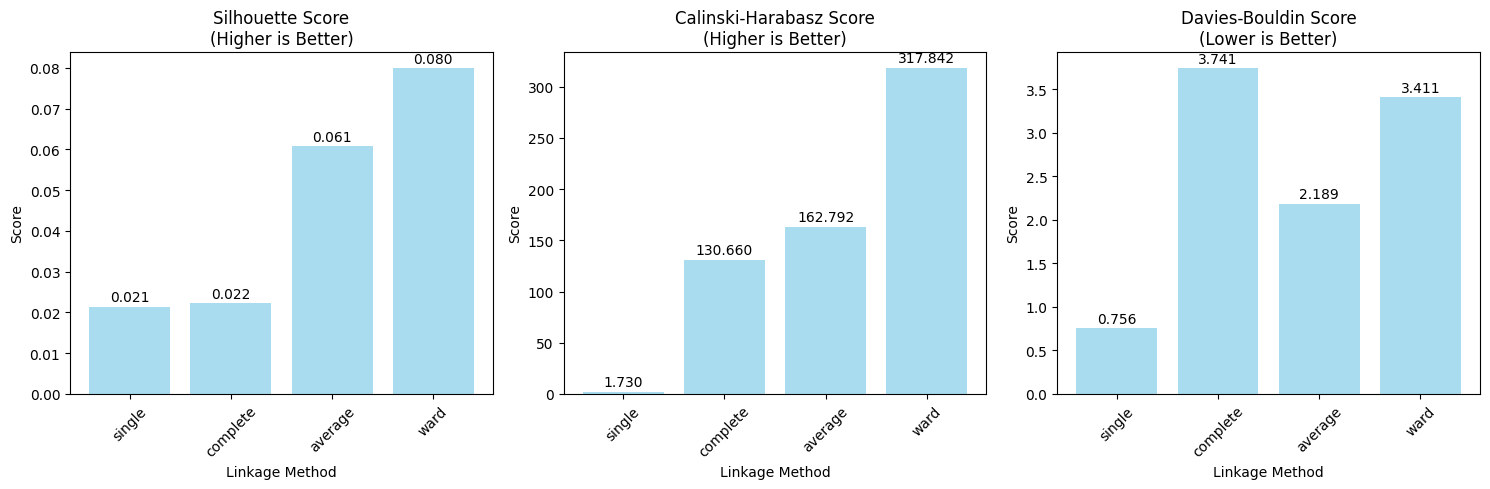


BEST PERFORMING METHODS:
Highest Silhouette Score: ward (0.0799)
Highest Calinski-Harabasz Score: ward (317.8421)
Lowest Davies-Bouldin Score: single (0.7559)

OVERALL BEST METHOD: WARD LINKAGE
DETAILED ANALYSIS FOR WARD LINKAGE

Cluster 0 (589 samples, 15.1%):
----------------------------------------
Demographics:
  Average Age: 49.8
  Gender Distribution: {'Male': np.int64(586), 'Female': np.int64(3)}
Purchase Behavior:
  Average Purchase Amount: $47.98
  Average Review Rating: 3.58
  Average Previous Purchases: 28.8
Preferences:
  Top Category: Clothing
  Top Season: Spring
  Most Common Frequency: Quarterly
  Subscription Status: {'No': np.int64(589)}

Cluster 1 (1014 samples, 26.0%):
----------------------------------------
Demographics:
  Average Age: 40.4
  Gender Distribution: {'Male': np.int64(1008), 'Female': np.int64(6)}
Purchase Behavior:
  Average Purchase Amount: $66.56
  Average Review Rating: 3.86
  Average Previous Purchases: 23.4
Preferences:
  Top Category: Clothing

silhouette_score  silhouette_rank  calinski_harabasz_score  \
ward              0.079866              1.0               317.842076   
average           0.060782              2.0               162.791618   
single            0.021448              4.0                 1.729681   
complete          0.022248              3.0               130.660155   

          calinski_rank  
ward                1.0  
average             2.0  
single              4.0  
complete            3.0

In [13]:
performance_results = {}

print("CLUSTERING PERFORMANCE EVALUATION")
print("=" * 50)

for method in linkage_methods:
    if method in clustering_results:
        labels = clustering_results[method]['labels']
        
        # Calculate metrics
        silhouette = silhouette_score(normalized_features, labels)
        calinski = calinski_harabasz_score(normalized_features, labels)
        davies_bouldin = davies_bouldin_score(normalized_features, labels)
        
        performance_results[method] = {
            'silhouette_score': silhouette,
            'calinski_harabasz_score': calinski,
            'davies_bouldin_score': davies_bouldin
        }
        
        print(f"\n{method.capitalize()} Linkage:")
        print(f"  Silhouette Score: {silhouette:.4f}")
        print(f"  Calinski-Harabasz Score: {calinski:.4f}")
        print(f"  Davies-Bouldin Score: {davies_bouldin:.4f}")

# Create performance comparison DataFrame
performance_df = pd.DataFrame(performance_results).T
print("\nPerformance Summary:")
performance_df.round(4)

# Visualize performance metrics
plt.figure(figsize=(15, 5))

metrics = ['silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score']
metric_names = ['Silhouette Score\n(Higher is Better)', 
                'Calinski-Harabasz Score\n(Higher is Better)', 
                'Davies-Bouldin Score\n(Lower is Better)']

for i, (metric, name) in enumerate(zip(metrics, metric_names), 1):
    plt.subplot(1, 3, i)
    methods_list = list(performance_results.keys())
    values = [performance_results[method][metric] for method in methods_list]
    bars = plt.bar(methods_list, values, color='skyblue', alpha=0.7)
    plt.title(name)
    plt.xlabel('Linkage Method')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, 
                bar.get_height() + (max(values) - min(values))*0.01,
                f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Find best performing method for each metric
print("\nBEST PERFORMING METHODS:")
print("=" * 25)
print(f"Highest Silhouette Score: {performance_df['silhouette_score'].idxmax()} "
      f"({performance_df['silhouette_score'].max():.4f})")
print(f"Highest Calinski-Harabasz Score: {performance_df['calinski_harabasz_score'].idxmax()} "
      f"({performance_df['calinski_harabasz_score'].max():.4f})")
print(f"Lowest Davies-Bouldin Score: {performance_df['davies_bouldin_score'].idxmin()} "
      f"({performance_df['davies_bouldin_score'].min():.4f})")

# Overall best method (based on silhouette score)
best_method = performance_df['silhouette_score'].idxmax()
print(f"\nOVERALL BEST METHOD: {best_method.upper()} LINKAGE")

# Detailed cluster analysis for the best performing method
best_labels = clustering_results[best_method]['labels']

print(f"DETAILED ANALYSIS FOR {best_method.upper()} LINKAGE")
print("=" * 60)

# Add cluster labels to original dataframe
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = best_labels

# Analyze each cluster
for cluster_id in sorted(df_with_clusters['Cluster'].unique()):
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_data)} samples, {len(cluster_data)/len(df)*100:.1f}%):")
    print("-" * 40)
    
    print("Demographics:")
    print(f"  Average Age: {cluster_data['Age'].mean():.1f}")
    print(f"  Gender Distribution: {dict(cluster_data['Gender'].value_counts())}")
    
    print("Purchase Behavior:")
    print(f"  Average Purchase Amount: ${cluster_data['Purchase Amount (USD)'].mean():.2f}")
    print(f"  Average Review Rating: {cluster_data['Review Rating'].mean():.2f}")
    print(f"  Average Previous Purchases: {cluster_data['Previous Purchases'].mean():.1f}")
    
    print("Preferences:")
    print(f"  Top Category: {cluster_data['Category'].mode().iloc[0]}")
    print(f"  Top Season: {cluster_data['Season'].mode().iloc[0]}")
    print(f"  Most Common Frequency: {cluster_data['Frequency of Purchases'].mode().iloc[0]}")
    print(f"  Subscription Status: {dict(cluster_data['Subscription Status'].value_counts())}")

# Create comprehensive performance comparison table
print("\nCOMPREHENSIVE PERFORMANCE COMPARISON")
print("=" * 40)

# Add rankings for each metric
performance_with_ranks = performance_df.copy()

# For silhouette and calinski-harabasz: higher is better (rank 1 = best)
performance_with_ranks['silhouette_rank'] = performance_df['silhouette_score'].rank(ascending=False)
performance_with_ranks['calinski_rank'] = performance_df['calinski_harabasz_score'].rank(ascending=False)

# For davies-bouldin: lower is better (rank 1 = best)
performance_with_ranks['davies_rank'] = performance_df['davies_bouldin_score'].rank(ascending=True)

# Calculate average rank
performance_with_ranks['average_rank'] = (performance_with_ranks['silhouette_rank'] + 
                                         performance_with_ranks['calinski_rank'] + 
                                         performance_with_ranks['davies_rank']) / 3

# Sort by average rank
performance_with_ranks = performance_with_ranks.sort_values('average_rank')

print("Ranking (1 = Best Performance):")
performance_with_ranks[['silhouette_score', 'silhouette_rank', 
                       'calinski_harabasz_score', 'calinski_rank']]